<a href="https://colab.research.google.com/github/valerian-drmt/Trading_Projects/blob/main/LSTM_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Librairies and Raw Data

## 1.1 - Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import vectorbt as vbt
import time
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import norm
import plotly.express as px
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torch
import os
import math
import psutil
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split
print(torch.__version__)

2.7.0+cpu


## 1.2 - Get Raw Data from API or File

| Interval       | Max Lookback Period (approx)  |
|----------------|-------------------------------|
| `'1m'`         | 7 days                        |
| `'2m'`         | 60 days                       |
| `'5m'`         | 60 days                       |
| `'15m'`        | 60 days                       |
| `'30m'`        | 60 days                       |
| `'60m'` / `'1h'` | 730 days (~2 years)        |
| `'1d'`         | ~20+ years                    |
| `'1wk'`        | ~20+ years                    |
| `'1mo'`        | ~20+ years                    |

In [ ]:
def Get_Raw_Data(symbols, start, end, interval, With_file):
    import pandas as pd
    if not With_file:
      # Récupérer les données OHLCV depuis l'API Binance
      data_request = vbt.BinanceData.download(
          symbols= symbols,
          start = start,
          end = end,
          interval = interval
      )

      # Extraire les données OHLCV sous forme de DataFrame
      df = data_request.get()

      # Make sure the index is timezone-naive
      if df.index.tz is not None:
          df.index = df.index.tz_localize(None)

      # Also remove timezone from datetime columns (if any)
      for col in df.columns:
          if pd.api.types.is_datetime64tz_dtype(df[col]):
              df[col] = df[col].dt.tz_localize(None)

      # Save to Excel
      df.to_excel(f"BTCUSDT_{interval}.xlsx", index=True)
      print(f"BTCUSDT_{interval}.xlsx is in the folder")

      # Read Excel
      data_v0 = pd.read_excel(f"BTCUSDT_{interval}.xlsx").set_index("Open time")

    #---------------------------------------------------------------------------
    else:
      Codelab=False
      if Codelab:
        from google.colab import files
        uploaded = files.upload()

      # Assume that the uploaded file name is correct
      data_v0 = pd.read_excel(f"BTCUSDT_{interval}.xlsx")
      data_v0 = data_v0.set_index("Open time")

    return data_v0

## 1.3 - Test and Debug

In [ ]:
With_file = True
symbols="BTCUSDT"
start="2025-02-03"
end="2025-04-06"
interval="1m"

data_v0 = Get_Raw_Data(symbols, start, end, interval, With_file)

print(data_v0.head())
print(data_v0.columns)
print("Shape:", data_v0.shape)

                         Open      High       Low     Close    Volume  \
Open time                                                               
2025-02-02 22:00:00  97020.56  97245.54  96980.96  97245.54  38.56956   
2025-02-02 22:01:00  97245.54  97461.53  97245.53  97418.31  50.41245   
2025-02-02 22:02:00  97418.32  97514.46  97360.89  97376.62  31.50931   
2025-02-02 22:03:00  97376.62  97421.22  97300.00  97403.83  30.11589   
2025-02-02 22:04:00  97403.83  97501.97  97319.37  97443.72  38.74611   

                                 Close time  Quote volume  Number of trades  \
Open time                                                                     
2025-02-02 22:00:00 2025-02-02 22:00:59.999  3.745847e+06              9381   
2025-02-02 22:01:00 2025-02-02 22:01:59.999  4.908941e+06             11372   
2025-02-02 22:02:00 2025-02-02 22:02:59.999  3.070336e+06              8980   
2025-02-02 22:03:00 2025-02-02 22:03:59.999  2.931792e+06              6292   
2025-02-02 22:

# 2 - Features Class

## 2.1 - Main Class

In [ ]:
class LSTM_Features:
    def __init__(self, data):
        self.data = data

        methods = [resample_with_vwap, market_sessions, is_noise]
        for method in methods:
          method_name = method.__name__
          setattr(self, method_name, method.__get__(self))


## 2.2 - Definitions

### Resample with VWAP

In [ ]:
def resample_with_vwap(self, resample_period: str = '5min'):
    df = self.data

    resampled = pd.DataFrame()
    resampled['Open'] = df['Open'].resample(resample_period).first()
    resampled['High'] = df['High'].resample(resample_period).max()
    resampled['Low'] = df['Low'].resample(resample_period).min()
    resampled['Close'] = df['Close'].resample(resample_period).last()
    resampled['Volume'] = df['Volume'].resample(resample_period).sum()
    resampled['Quote volume'] = df['Quote volume'].resample(resample_period).sum()
    resampled['Number of trades'] = df['Number of trades'].resample(resample_period).sum()
    resampled['Taker base volume'] = df['Taker base volume'].resample(resample_period).sum()
    resampled['Taker quote volume'] = df['Taker quote volume'].resample(resample_period).sum()

    # VWAP calculation from original data
    vwap_numerator = (df['Close'] * df['Volume']).resample(resample_period).sum()
    vwap_denominator = df['Volume'].resample(resample_period).sum()
    resampled['VWAP_5m'] = vwap_numerator / vwap_denominator

    self.data = resampled  # safe overwrite after complete resampling
    return self

### Market Sessions

🕒 Market Opening Hours (Paris Time)

| Market     | Opening Hours (Paris Time) | Opening Hours (UTC) |
|------------|-----------------------------|----------------------|
| 🇭🇰 **Hong Kong / Tokyo** | 01:00 – 07:00                    | 00:00 – 06:00         |
| 🇬🇧 **London**            | 09:00 – 17:30                    | 08:00 – 16:30         |
| 🇺🇸 **New York**          | 15:30 – 22:00                    | 13:30 – 20:00         |

> ⚠️ Note: Hours may shift by 1 hour during daylight saving time transitions.

In [ ]:
def market_sessions(self):
  # Make sure datetime index is correct
  self.data.index = pd.to_datetime(self.data.index)
  self.data.index = self.data.index.tz_localize(None)

  # Functions to check sessions
  def is_london_open(hour, minute):
      return (9 < hour < 17) or (hour == 17 and minute <= 30)

  def is_ny_open(hour, minute):
      return (16 <= hour < 22) or (hour == 15 and minute >= 30) or (hour == 22 and minute == 0)

  def is_tokyo_open(hour, minute):
      return (1 <= hour < 7)

  # Directly create session flags
  self.data['London_Open'] = self.data.index.map(lambda ts: int(is_london_open(ts.hour, ts.minute)))
  self.data['NY_Open'] = self.data.index.map(lambda ts: int(is_ny_open(ts.hour, ts.minute)))
  self.data['HK_Open'] = self.data.index.map(lambda ts: int(is_tokyo_open(ts.hour, ts.minute)))

  return self

### Is Noise

In [ ]:
def is_noise(self, noise_ratio):
        df = self.data.copy()

        # Calcul de la range (High - Low)
        df['Range'] = df['High'] - df['Low']

        # Normalisation min-max
        vol_norm = (df['Volume'] - df['Volume'].min()) / (df['Volume'].max() - df['Volume'].min())
        range_norm = (df['Range'] - df['Range'].min()) / (df['Range'].max() - df['Range'].min())

        # Score de silence (plus c’est élevé, plus c’est du bruit potentiel)
        silence_score = (1 - vol_norm) + (1 - range_norm)
        df['Silence_Score'] = silence_score

        # Seuil automatique : garder les N% plus silencieuses
        threshold = df['Silence_Score'].quantile(1 - noise_ratio)
        df['Is_Noise'] = (df['Silence_Score'] >= threshold).astype(int)

        # Nettoyage
        df.drop(columns=['Range', 'Silence_Score'], inplace=True)

        self.data = df
        return self

### Pivot Points

In [ ]:
from collections import deque
def clean_deque(i, k, deq, df, key, isHigh):
    if deq and deq[0] == i - k:
        deq.popleft()
    if isHigh:
        while deq and df.iloc[i][key] > df.iloc[deq[-1]][key]:
            deq.pop()
    else:
        while deq and df.iloc[i][key] < df.iloc[deq[-1]][key]:
            deq.pop()


def pivotPoints(data1, pivot_left, pivot_right):
    data = data1[["High", "Low"]].copy()

    data['H'] = False
    data['L'] = False

    keyHigh = 'High'
    keyLow = 'Low'

    win_size = pivot_left + pivot_right + 1  # asymmetrical window
    deqHigh = deque()
    deqLow = deque()

    max_idx = 0
    min_idx = 0
    i = 0
    j = pivot_left  # pivot center is after pivot_left bars
    pivot_low = None
    pivot_high = None

    for index, row in data.iterrows():
        if i < win_size:
            clean_deque(i, win_size, deqHigh, data, keyHigh, True)
            clean_deque(i, win_size, deqLow, data, keyLow, False)
            deqHigh.append(i)
            deqLow.append(i)

            if data.iloc[i][keyHigh] > data.iloc[max_idx][keyHigh]:
                max_idx = i
            if data.iloc[i][keyLow] < data.iloc[min_idx][keyLow]:
                min_idx = i

            if i == win_size - 1:
                if data.iloc[max_idx][keyHigh] == data.iloc[j][keyHigh]:
                    data.at[data.index[j], 'H'] = True
                    pivot_high = data.iloc[j][keyHigh]
                if data.iloc[min_idx][keyLow] == data.iloc[j][keyLow]:
                    data.at[data.index[j], 'L'] = True
                    pivot_low = data.iloc[j][keyLow]

        elif i >= win_size:
            j += 1
            clean_deque(i, win_size, deqHigh, data, keyHigh, True)
            clean_deque(i, win_size, deqLow, data, keyLow, False)
            deqHigh.append(i)
            deqLow.append(i)

            pivot_val = data.iloc[deqHigh[0]][keyHigh]
            if pivot_val == data.iloc[j][keyHigh]:
                data.at[data.index[j], 'H'] = True
                pivot_high = data.iloc[j][keyHigh]
            if data.iloc[deqLow[0]][keyLow] == data.iloc[j][keyLow]:
                data.at[data.index[j], 'L'] = True
                pivot_low = data.iloc[j][keyLow]

        data.at[data.index[j], 'Last_High_Value'] = pivot_high
        data.at[data.index[j], 'Last_Low_Value'] = pivot_low
        i += 1


    data.drop(columns=['H', 'L'], inplace=True)
    return data

0it [00:00, ?it/s]

(576, 4)
                               High       Low Last_High_Value Last_Low_Value
Open time                                                                   
2025-04-28 22:00:00+00:00  94607.92  94486.00             NaN            NaN
2025-04-28 22:05:00+00:00  94710.64  94529.96             NaN            NaN
2025-04-28 22:10:00+00:00  94660.00  94560.29             NaN            NaN
2025-04-28 22:15:00+00:00  94708.24  94515.07             NaN            NaN
2025-04-28 22:20:00+00:00  94544.01  94480.00             NaN            NaN
2025-04-28 22:25:00+00:00  94565.22  94500.00             NaN            NaN
2025-04-28 22:30:00+00:00  94636.00  94480.00             NaN            NaN
2025-04-28 22:35:00+00:00  94687.19  94596.85             NaN            NaN
2025-04-28 22:40:00+00:00  94663.06  94576.00             NaN            NaN
2025-04-28 22:45:00+00:00  94793.70  94623.80             NaN            NaN
2025-04-28 22:50:00+00:00  94877.33  94769.20             NaN      

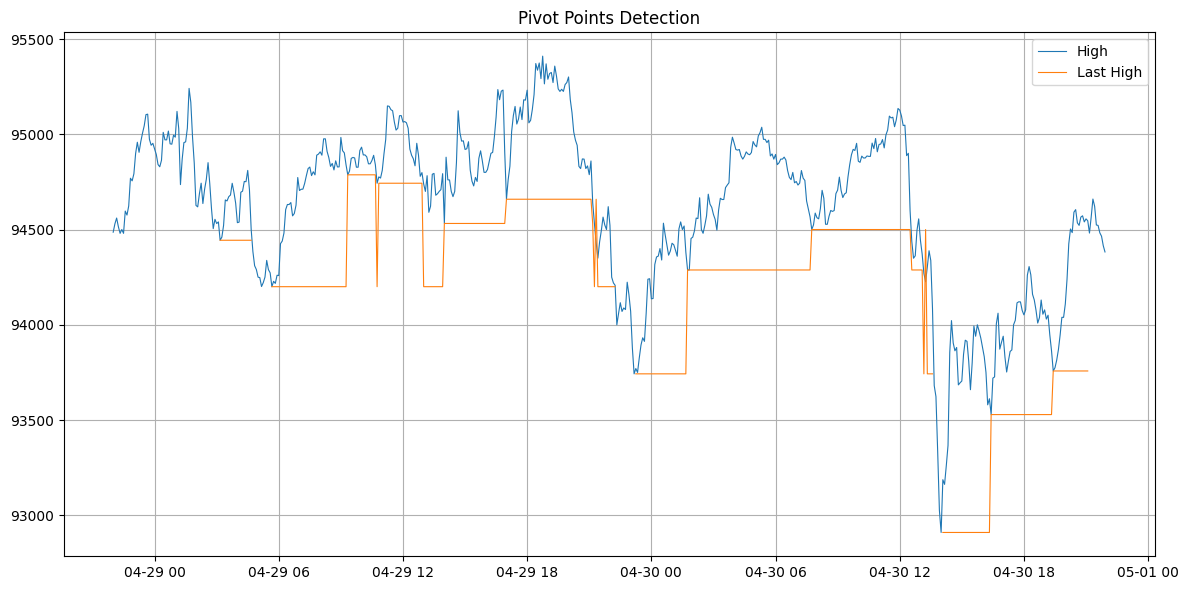

In [ ]:
from collections import deque

#----------------------------------------------------------------

def clean_deque(i, k, deq, df, key, isHigh):
    if deq and deq[0] == i - k:
        deq.popleft()
    if isHigh:
        while deq and df.iloc[i][key] > df.iloc[deq[-1]][key]:
            deq.pop()
    else:
        while deq and df.iloc[i][key] < df.iloc[deq[-1]][key]:
            deq.pop()

#----------------------------------------------------------------

def pivotPoints(data1, pivot_left, pivot_right):
    data = data1[["High", "Low"]].copy()

    data['H'] = False
    data['L'] = False

    keyHigh = 'High'
    keyLow = 'Low'

    win_size = pivot_left + pivot_right + 1  # asymmetrical window
    deqHigh = deque()
    deqLow = deque()

    max_idx = 0
    min_idx = 0
    i = 0
    j = pivot_left  # pivot center is after pivot_left bars
    pivot_low = None
    pivot_high = None

    for index, row in data.iterrows():
        if i < win_size:
            clean_deque(i, win_size, deqHigh, data, keyHigh, True)
            clean_deque(i, win_size, deqLow, data, keyLow, False)
            deqHigh.append(i)
            deqLow.append(i)

            if data.iloc[i][keyHigh] > data.iloc[max_idx][keyHigh]:
                max_idx = i
            if data.iloc[i][keyLow] < data.iloc[min_idx][keyLow]:
                min_idx = i

            if i == win_size - 1:
                if data.iloc[max_idx][keyHigh] == data.iloc[j][keyHigh]:
                    data.at[data.index[j], 'H'] = True
                    pivot_high = data.iloc[j][keyHigh]
                if data.iloc[min_idx][keyLow] == data.iloc[j][keyLow]:
                    data.at[data.index[j], 'L'] = True
                    pivot_low = data.iloc[j][keyLow]

        elif i >= win_size:
            j += 1
            clean_deque(i, win_size, deqHigh, data, keyHigh, True)
            clean_deque(i, win_size, deqLow, data, keyLow, False)
            deqHigh.append(i)
            deqLow.append(i)

            pivot_val = data.iloc[deqHigh[0]][keyHigh]
            if pivot_val == data.iloc[j][keyHigh]:
                data.at[data.index[j], 'H'] = True
                pivot_high = data.iloc[j][keyHigh]
            if data.iloc[deqLow[0]][keyLow] == data.iloc[j][keyLow]:
                data.at[data.index[j], 'L'] = True
                pivot_low = data.iloc[j][keyLow]

        data.at[data.index[j], 'Last_High_Value'] = pivot_high
        data.at[data.index[j], 'Last_Low_Value'] = pivot_low
        i += 1
    #----------------------------------------------------------------

    data.drop(columns=['H', 'L'], inplace=True)

    #----------------------------------------------------------------

    highs_list = []
    broken_high = None  # Initialize it before the loop

    for idx, row in data.iterrows():
        if pd.notna(row['Last_High_Value']):
            if len(highs_list) == 0:
                highs_list.append(row['Last_High_Value'])
            else:
                if row["High"] > highs_list[-1]:  # if current high breaks the last high
                    broken_high = highs_list.pop()
                    data.at[idx, 'Last_High_Value'] = highs_list[-1] if highs_list else None

                elif broken_high is not None and row['Last_High_Value'] == broken_high:
                    data.at[idx, 'Last_High_Value'] = highs_list[-1] if highs_list else None
                else:
                    if row['Last_High_Value'] != highs_list[-1]:
                        highs_list.append(row['Last_High_Value'])

    #----------------------------------------------------------------

    lows_list = []
    broken_low = None  # Initialize before the loop

    for idx, row in data.iterrows():
        if pd.notna(row['Last_Low_Value']):
            if len(lows_list) == 0:
                lows_list.append(row['Last_Low_Value'])
            else:
                if row["Low"] < lows_list[-1]:  # if current low breaks the last low
                    broken_low = lows_list.pop()
                    data.at[idx, 'Last_Low_Value'] = lows_list[-1] if lows_list else None

                elif broken_low is not None and row['Last_Low_Value'] == broken_low:
                    data.at[idx, 'Last_Low_Value'] = lows_list[-1] if lows_list else None
                else:
                    if row['Last_Low_Value'] != lows_list[-1]:
                        lows_list.append(row['Last_Low_Value'])

    #----------------------------------------------------------------

    return data






#-------------------------------------------------------------------------------
data = vbt.BinanceData.download(
    symbols="BTCUSDT",
    interval="5m",
    start="2025-04-29",
    end =" 2025-05-01"
).get()
#
 #start=pd.Timestamp.now(tz='UTC') - pd.Timedelta(days=7),
pivot_points = pivotPoints(data,pivot_left = 15, pivot_right = 10)

print(pivot_points.shape)
print(pivot_points[:25])

plt.figure(figsize=(12, 6))
"""plt.plot(data["High"], label="High", linewidth=0.8)
plt.plot(pivot_points["Last_High_Value"], label="Last High", linewidth=0.8)"""
plt.plot(data["Low"], label="High", linewidth=0.8)
plt.plot(pivot_points["Last_Low_Value"], label="Last High", linewidth=0.8)
plt.legend()
plt.title("Pivot Points Detection")
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.3 - Test and Debug

Shape: (11808, 14)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote volume',
       'Number of trades', 'Taker base volume', 'Taker quote volume',
       'VWAP_5m', 'London_Open', 'NY_Open', 'HK_Open', 'Is_Noise'],
      dtype='object')

Session Open/Close Frequency:
   London_Open  NY_Open  HK_Open
0         8077     8569     8856
1         3731     3239     2952

Noise Label Frequency:
Is_Noise
0    10036
1     1772
Name: count, dtype: int64


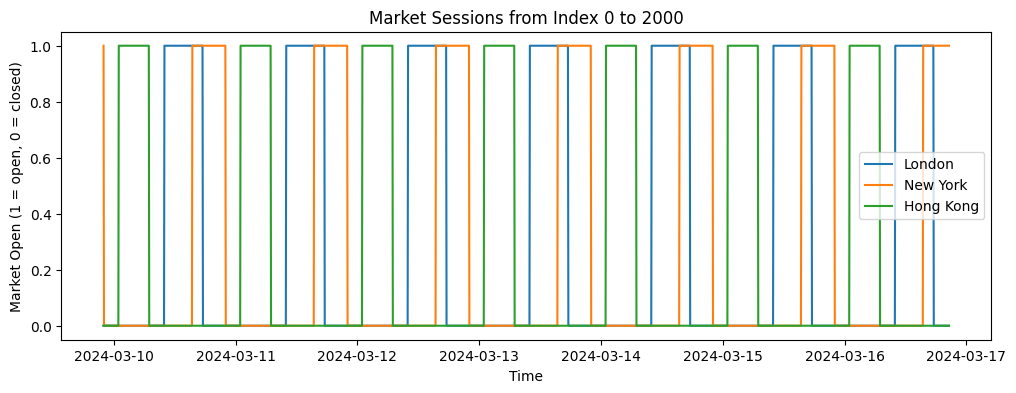

#----------------------------------------------------------------------


In [ ]:
# Step 0: Initialize Features Dataframe
Features_Data = LSTM_Features(data_v0)
#-------------------------------------------------------------------------------

# Step 1: Market Sessions
resample_period = '5min'
Features_Data.resample_with_vwap(resample_period)

# Step 2: Market Sessions
Features_Data.market_sessions()

# Step 3: Market Sessions
noise_ratio = 0.15
Features_Data.is_noise(noise_ratio)
#-------------------------------------------------------------------------------

debug1 = True

if debug1:

    print("Shape:", Features_Data.data.shape)
    print(Features_Data.data.columns)

    # Additional Analysis Merket Sessions
    frequency = Features_Data.data[["London_Open", "NY_Open", "HK_Open"]].apply(
        lambda col: pd.Series(col).value_counts()
    ).fillna(0).astype(int)
    print("\nSession Open/Close Frequency:")
    print(frequency)

    # Additional Analysis Is Noise
    frequency = Features_Data.data["Is_Noise"].value_counts().sort_index()
    print("\nNoise Label Frequency:")
    print(frequency)

    # Plotting
    nb = 2000
    plt.figure(figsize=(12, 4))
    plt.plot(Features_Data.data["London_Open"].iloc[:nb], label="London")
    plt.plot(Features_Data.data["NY_Open"].iloc[:nb], label="New York")
    plt.plot(Features_Data.data["HK_Open"].iloc[:nb], label="Hong Kong")
    plt.legend()
    plt.title(f"Market Sessions from Index 0 to {nb}")
    plt.xlabel("Time")
    plt.ylabel("Market Open (1 = open, 0 = closed)")
    plt.show()
print("#----------------------------------------------------------------------")

# Last Step: Refresh Data
Features_Data.data = None

# 3 - Labels Class

## 3.1 - Main Class

In [ ]:
class LSTM_Labels():
    def __init__(self, data , look_forward :int, n_categories : int):
        self.data = data
        self.look_forward = look_forward
        self.n_categories = n_categories
        self.boundaries = None

        methods = [categorize_with_std]
        for method in methods:
          method_name = method.__name__
          setattr(self, method_name, method.__get__(self))

## 3.2 - Definitions

### Categorize with std

In [ ]:
def categorize_with_std(self):

        # 1. Calculate the Return and the Z-Score
        self.data["Return"] = self.data["Price"].shift(-self.look_forward) / self.data["Price"] - 1
        mean = self.data["Return"].mean()
        std = self.data["Return"].std()
        self.data["Return Z-Score"] = (self.data["Return"] - mean) / std

        # 2. Define category boundaries based on standard deviation multiples
        n = self.n_categories
        max_std = 3  # Cover most of the normal distribution (-3σ to +3σ)
        self.boundaries = np.linspace(-max_std, max_std, n + 1)


        # 3. Calculate frequencies assuming normal distribution
        category_frequencies = []
        for i in range(len(self.boundaries) - 1):
            prob = norm.cdf(self.boundaries[i + 1]) - norm.cdf(self.boundaries[i])
            category_frequencies.append(prob)

        category_frequencies = np.array(category_frequencies)

        # 4. Function to categorize a Z-score
        def categorize_zscore(z, bounds):
            if pd.isna(z):
                return np.nan
            for i in range(len(bounds) - 1):
                if bounds[i] <= z < bounds[i + 1]:
                    return i
            return np.nan  # In case z is outside boundaries due to numerical issues

        # 5. Create Category_Close (current Return Z-Score category)
        self.data["Category_Close"] = self.data["Return Z-Score"].apply(lambda z: categorize_zscore(z, self.boundaries))

        # 6. Calculate High and Low Z-Scores over the past 20 candles
        self.data["High_20"] = self.data["Price"].rolling(window=20).max()
        self.data["Low_20"] = self.data["Price"].rolling(window=20).min()

        self.data["High_20_Return"] = self.data["High_20"].shift(-self.look_forward) / self.data["Price"] - 1
        self.data["Low_20_Return"] = self.data["Low_20"].shift(-self.look_forward) / self.data["Price"] - 1

        self.data["High_20_Z-Score"] = (self.data["High_20_Return"] - mean) / std
        self.data["Low_20_Z-Score"] = (self.data["Low_20_Return"] - mean) / std

        # 7. Create Category_High and Category_Low
        self.data["Category_High"] = self.data["High_20_Z-Score"].apply(lambda z: categorize_zscore(z, self.boundaries))
        self.data["Category_Low"] = self.data["Low_20_Z-Score"].apply(lambda z: categorize_zscore(z, self.boundaries))

        # 8. Clean up intermediate columns if you want (optional)
        self.data.drop(columns=["Return", "Return Z-Score", "High_20", "Low_20", "High_20_Return", "Low_20_Return", "High_20_Z-Score", "Low_20_Z-Score"], inplace=True)

        return self

## 3.2 - Test and debug

                         Open      High       Low     Close    Volume  \
Open time                                                               
2024-03-09 22:00:00  68376.13  68381.04  68333.33  68375.96  52.71494   
2024-03-09 22:05:00  68375.96  68400.00  68371.03  68394.01  22.22946   
2024-03-09 22:10:00  68394.02  68394.02  68355.37  68385.14  43.19212   
2024-03-09 22:15:00  68385.13  68411.32  68385.13  68400.00  33.44396   
2024-03-09 22:20:00  68400.00  68400.01  68316.41  68357.93  52.44704   

                     Quote volume  Number of trades  Taker base volume  \
Open time                                                                
2024-03-09 22:00:00  3.603736e+06              4830           21.46722   
2024-03-09 22:05:00  1.520165e+06              3028           10.96336   
2024-03-09 22:10:00  2.953149e+06              4627           22.96767   
2024-03-09 22:15:00  2.287747e+06              2649           11.35598   
2024-03-09 22:20:00  3.584746e+06           

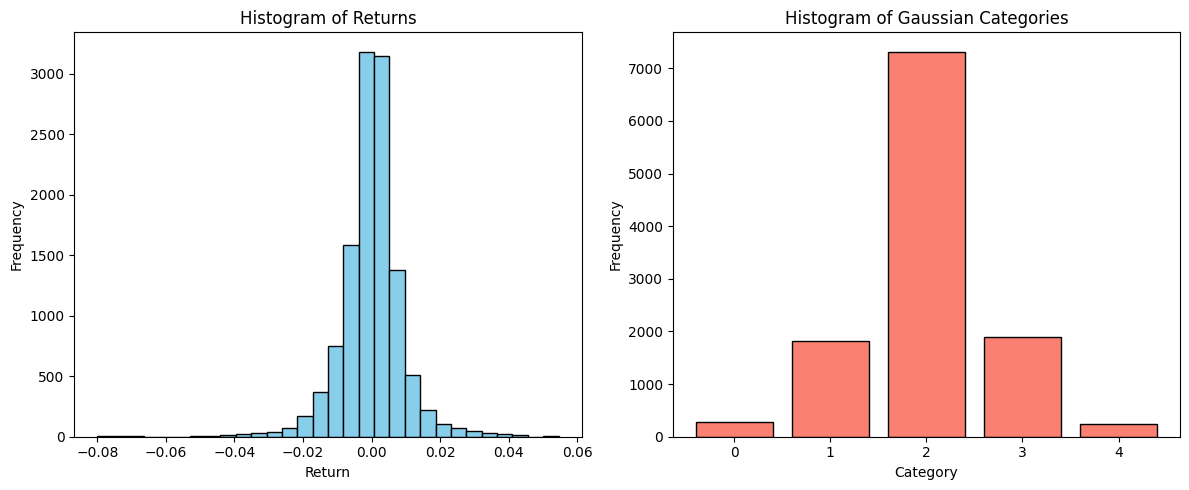

In [ ]:
Features_Data = LSTM_Features(data_v0).resample_with_vwap("5min").is_noise(0.2)

#------------------------------------------------------------------------

Labels_Data = LSTM_Labels(Features_Data.data, look_forward = 20, n_categories = 5)
Labels_Data.data["Price"] = Labels_Data.data["VWAP_5m"]
Labels_Data.categorize_with_std()

print(Labels_Data.data.head())
print("Boudaries: ", Labels_Data.boundaries)

# Count the number of points (no normalization)
close_counts = Labels_Data.data["Category_Close"].value_counts(normalize=False).sort_index()
high_counts = Labels_Data.data["Category_High"].value_counts(normalize=False).sort_index()
low_counts = Labels_Data.data["Category_Low"].value_counts(normalize=False).sort_index()
print(close_counts.shape, high_counts.shape, low_counts.shape)
"""
table = pd.DataFrame({
    'Low Count': low_counts.values,
    'Close Count': close_counts.values,
    'High Count': high_counts.values
}, index=close_counts.index)
print(table)"""

# Verification
plt.figure(figsize=(12, 5))

# Histogramme des future returns
plt.subplot(1, 2, 1)
plt.hist(Labels_Data.data["Price"].pct_change(Labels_Data.look_forward).dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")

# Histogramme des catégories gaussiennes
plt.subplot(1, 2, 2)
plt.hist(Labels_Data.data["Category_Close"].dropna(), bins=np.arange(Labels_Data.n_categories + 1) - 0.5, color='salmon', edgecolor='black', rwidth=0.8)
plt.xticks(range(Labels_Data.n_categories))
plt.title("Histogram of Gaussian Categories")
plt.xlabel("Category")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Last Step: Refresh Data
Features_Data.data = None
Labels_Data.data = None

# 4 - Split Data to get Train/Test

## 4.1 - Definition

In [ ]:
def split_data(train_test_data, lookback, size_test_prct):
    # 1. Split automatically: features = columns starting with "Feature_", labels = columns starting with "Label_"
    feature_cols = [col for col in train_test_data.columns if col.startswith("Feature")]
    label_cols = [col for col in train_test_data.columns if col.startswith("Label")]

    # 2. Convert to numpy arrays
    features = train_test_data[feature_cols].values  # shape (N, n_features)
    labels = train_test_data[label_cols].values      # shape (N, n_labels)

    # 3. Normalize only the features (per feature column)
    features = (features - features.min(axis=0)) / (features.max(axis=0) - features.min(axis=0))

    # 4. Stack features and labels together
    data_all = np.hstack((features, labels))  # shape (N, n_features + n_labels)

    # 5. Create sequences
    data = []
    for index in range(len(data_all) - lookback):
        data.append(data_all[index: index + lookback])

    data = np.array(data)  # shape (num_sequences, lookback, n_features + n_labels)

    # 6. Split train / test
    test_set_size = int(np.round(size_test_prct * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    # ➔ x = all features
    # ➔ y = all labels
    x_train = data[:train_set_size, :, :len(feature_cols)]    # Take only features
    y_train = data[:train_set_size, -1, len(feature_cols):]    # Take only labels (last time step)
    x_test = data[train_set_size:, :, :len(feature_cols)]
    y_test = data[train_set_size:, -1, len(feature_cols):]

    # 7. Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()

    return x_train, y_train, x_test, y_test

## 4.2 - Test and Debug

In [ ]:
lookback = 100
size_test_prct = 0.3
#------------------------------------------------------------------------

Features_Data = LSTM_Features(data_v0).resample_with_vwap("5min").market_sessions()

#------------------------------------------------------------------------

Labels_Data = LSTM_Labels(Features_Data.data, look_forward = 20, n_categories = 5)
Labels_Data.data["Price"] = Labels_Data.data["Close"]
Labels_Data.categorize_with_std()

#-------------------------------------------------------------------------------

train_test_data = pd.DataFrame({"Feature_1": Labels_Data.data["VWAP_5m"],
                                "Feature_2": Labels_Data.data["London_Open"],
                                "Feature_3": Labels_Data.data["NY_Open"],
                                "Feature_4": Labels_Data.data["HK_Open"],
                                "Label_1": Labels_Data.data["Category_Low"],
                                "Label_2": Labels_Data.data["Category_Close"],
                                "Label_3": Labels_Data.data["Category_High"]
                                }).dropna()

x_train, y_train, x_test, y_test = split_data(train_test_data, lookback, size_test_prct)

#-------------------------------------------------------------------------------
#Verification

debug = True
if debug:
  print("-----------------------------------------------------------------------")
  print("Feature Columns: ",Features_Data.data.columns)
  print("-----------------------------------------------------------------------")
  print(Labels_Data.data.head())
  print("-----------------------------------------------------------------------")
  print("Label Columns: ", Labels_Data.data.columns)
  print("-----------------------------------------------------------------------")
  print("Test Train Columns: ", train_test_data.columns)
  print("-----------------------------------------------------------------------")
  print("Train: ",x_train.shape, y_train.shape)
  print("Test: ",x_test.shape, y_test.shape)
  print("-----------------------------------------------------------------------")
  counts = pd.Series(y_test[:, 1].cpu().numpy()).value_counts(normalize=False).sort_index()
  table = pd.DataFrame({
      'Count': counts.values,
  }, index=counts.index)
  print(table)
  print("-----------------------------------------------------------------------")
  for i in range(y_train.shape[1]):  # Loop over each label
    print(f"Label {i}:")
    print(pd.Series(y_train[:, i].cpu().numpy()).value_counts(normalize=False).sort_index())
    print()

-----------------------------------------------------------------------
Feature Columns:  Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote volume',
       'Number of trades', 'Taker base volume', 'Taker quote volume',
       'VWAP_5m', 'London_Open', 'NY_Open', 'HK_Open', 'Price',
       'Category_Close', 'Category_High', 'Category_Low'],
      dtype='object')
-----------------------------------------------------------------------
                         Open      High       Low     Close    Volume  \
Open time                                                               
2024-03-09 22:00:00  68376.13  68381.04  68333.33  68375.96  52.71494   
2024-03-09 22:05:00  68375.96  68400.00  68371.03  68394.01  22.22946   
2024-03-09 22:10:00  68394.02  68394.02  68355.37  68385.14  43.19212   
2024-03-09 22:15:00  68385.13  68411.32  68385.13  68400.00  33.44396   
2024-03-09 22:20:00  68400.00  68400.01  68316.41  68357.93  52.44704   

                     Quote volume  Number of t

# 5 - LSTM Class

## 5.1 - Main Class

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim, num_epochs, n_labels, n_categories, dropout_p=0.3):
    super(LSTM, self).__init__()

    self.num_layers = num_layers
    self.lstm_layers = nn.ModuleList()
    self.dropout_layers = nn.ModuleList()
    self.num_epochs = num_epochs
    self.n_labels = n_labels
    self.n_categories = n_categories

    self.criterion = None

    # Tracking metrics
    self.hist_criterion = []
    self.hist_acc = []
    self.hist_f1 = []
    self.hist_precision = []
    self.hist_recall = []


    # Build LSTM layers + Dropout layers
    self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim[0], batch_first=True))
    self.dropout_layers.append(nn.Dropout(p=dropout_p))

    for i in range(1, self.num_layers):
        self.lstm_layers.append(nn.LSTM(hidden_dim[i-1], hidden_dim[i], batch_first=True))
        self.dropout_layers.append(nn.Dropout(p=dropout_p))

    self.fc = nn.Linear(hidden_dim[-1], output_dim)

    #---------------------------------------------------------------------------
    #Add all definitions
    methods = [forward, multi_task_loss, update_metrics, get_pred, show_metrics, visualize_classification_results]

    for method in methods:
      method_name = method.__name__
      setattr(self, method_name, method.__get__(self))


## 5.2 - Definitions

### Forward

In [ ]:
def forward(self, x):
    out = x
    for lstm, dropout in zip(self.lstm_layers, self.dropout_layers):
        out, _ = lstm(out)
        out = dropout(out)  # Apply Dropout after each LSTM

    out = out[:, -1, :]  # Take the last output
    out = self.fc(out)   # Shape: (batch_size, output_dim = n_labels * n_categories)

    # Split output into n_labels parts (e.g., 3 parts of 7 classes)
    out_split = torch.split(out, self.n_categories, dim=1)  # List of tensors [(batch, 7), (batch, 7), (batch, 7)]

    return out_split  # tuple of outputs per task

### Multi-Task Loss

In [ ]:
def multi_task_loss(self, outputs, targets):
    """
    Compute average CrossEntropyLoss over multiple outputs.
    - outputs: list of tensors (batch_size, n_categories)
    - targets: tensor (batch_size, n_labels) with class indices
    """
    loss_fn = nn.CrossEntropyLoss()
    losses = [
        loss_fn(output, targets[:, i])
        for i, output in enumerate(outputs)
    ]
    return sum(losses) / len(losses)

### Update Metrics

In [ ]:
def update_metrics(self, y_train_pred, y_train):

        total_loss = 0
        y_pred_list = []
        y_true_list = []

        for i in range(self.n_labels):
            pred = y_train_pred[:, i*self.n_categories:(i+1)*self.n_categories]
            true = y_train[:, i]
            loss = self.criterion(pred, true)
            total_loss += loss / self.n_labels

            pred_classes = torch.argmax(pred, dim=1)
            y_pred_list.append(pred_classes.detach().cpu().numpy())
            y_true_list.append(true.detach().cpu().numpy())

        # Concatenate all predictions and truths
        y_pred_np = np.concatenate(y_pred_list)
        y_true_np = np.concatenate(y_true_list)

        acc = accuracy_score(y_true_np, y_pred_np)
        f1 = f1_score(y_true_np, y_pred_np, average='weighted')
        prec = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
        rec = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

        self.hist_criterion.append(total_loss.item())
        self.hist_acc.append(acc)
        self.hist_f1.append(f1)
        self.hist_precision.append(prec)
        self.hist_recall.append(rec)

        return total_loss

### Get Predicion

In [ ]:
def get_pred(self, x_test):
    self.eval()
    with torch.no_grad():
        y_pred_split = self(x_test)  # tuple/list of n_labels tensors
        y_pred_concat = torch.cat(y_pred_split, dim=1)  # (batch_size, n_labels * n_categories)

    y_test_pred = []
    for i in range(self.n_labels):
        pred = y_pred_concat[:, i * self.n_categories : (i + 1) * self.n_categories]
        pred_class = torch.argmax(pred, dim=1)
        y_test_pred.append(pred_class)

    y_test_pred = torch.stack(y_test_pred, dim=1)  # (batch_size, n_labels)

    return y_test_pred, y_pred_concat


### Show Metrics

In [ ]:
def show_metrics(self, y_test, y_test_pred, y_test_pred_list):
    # Conversion en NumPy
    y_test_np = y_test.detach().cpu().numpy()
    y_test_pred_np = y_test_pred.detach().cpu().numpy()

    # Flatten to compare all labels
    y_test_np = y_test_np.flatten()
    y_test_pred_np = y_test_pred_np.flatten()

    # Métriques test
    acc_test = accuracy_score(y_test_np, y_test_pred_np)
    f1_test = f1_score(y_test_np, y_test_pred_np, average='weighted')
    precision_test = precision_score(y_test_np, y_test_pred_np, average='weighted', zero_division=0)
    recall_test = recall_score(y_test_np, y_test_pred_np, average='weighted', zero_division=0)

    total_loss = 0
    for i in range(self.n_labels):
        pred = y_test_pred_list[:, i*self.n_categories:(i+1)*self.n_categories]
        true = y_test[:, i]
        loss = self.criterion(pred, true)
        total_loss += loss / self.n_labels
    loss_test = total_loss.item()

    # Moyenne des métriques train
    acc_train = np.mean(self.hist_acc[-int(self.num_epochs * 0.2):])
    f1_train = np.mean(self.hist_f1[-int(self.num_epochs * 0.2):])
    precision_train = np.mean(self.hist_precision[-int(self.num_epochs * 0.2):])
    recall_train = np.mean(self.hist_recall[-int(self.num_epochs * 0.2):])
    loss_train = np.mean(self.hist_criterion[-int(self.num_epochs * 0.2):])

    # Tableau final
    metrics_data = {
        'Train': [acc_train, f1_train, precision_train, recall_train, loss_train],
        'Test':  [acc_test, f1_test, precision_test, recall_test, loss_test]
    }

    metrics_df = pd.DataFrame(metrics_data, index=['Accuracy', 'F1-score', 'Precision', 'Recall', 'Loss'])

    print("\n📊 Résumé des métriques de classification :\n")
    print(metrics_df.round(4))

    print("---------------------------------")
    print("Accuracy = proportion de prédictions correctes sur l’ensemble des classes.")
    print("Precision = parmi les prédictions positives, combien sont réellement correctes.")
    print("Recall = parmi les vrais positifs, combien le modèle a réussi à capturer.")
    print("F1-score = compromis entre precision et recall, utile en cas de classes déséquilibrées.")
    print("Loss = mesure l’erreur globale du modèle, plus elle est basse, mieux c’est.")
    print("---------------------------------")

    # Plot Metrics
    metrics = [self.hist_criterion, self.hist_acc, self.hist_f1, self.hist_precision, self.hist_recall]
    titles = ['CrossEntropy Loss', 'Accuracy', 'F1-score', 'Precision', 'Recall']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    ylabel = ['Score'] * 4 + ['Loss']

    epochs = range(1, len(self.hist_acc) + 1)
    fig, axs = plt.subplots(1, 5, figsize=(22, 4))

    for i, ax in enumerate(axs):
        ax.plot(epochs, metrics[i], color=colors[i])
        ax.set_title(titles[i])
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel[i])
        ax.grid(True)

    plt.tight_layout()
    plt.suptitle('Training Metrics per Epoch', fontsize=16, y=1.05)
    plt.show()

    return self

### Visualize Classification Results

In [ ]:
def visualize_classification_results(self, y_true, y_pred, n_categories, sequence_title="True vs Predicted", max_points=150):
    """
    Displays for each label dimension:
    - Confusion matrix (heatmap)
    - Class sequence (true vs pred)
    - Histogram of class distribution
    """

    # Convert to NumPy if Tensors
    if hasattr(y_true, 'detach'):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, 'detach'):
        y_pred = y_pred.detach().cpu().numpy()

    # If labels are 1D, add a dimension
    if y_true.ndim == 1:
        y_true = y_true[:, None]
        y_pred = y_pred[:, None]

    n_labels = y_true.shape[1]

    for label_idx in range(n_labels):
        print(f"Plotting for label {label_idx}")

        true_label = y_true[:, label_idx].flatten()
        pred_label = y_pred[:, label_idx].flatten()

        # Create figure with 3 side-by-side subplots
        fig, axs = plt.subplots(1, 3, figsize=(22, 5))
        plt.subplots_adjust(wspace=0.4)

        # 1. Confusion Matrix
        cm = confusion_matrix(true_label, pred_label, labels=range(n_categories))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=range(n_categories),
                    yticklabels=range(n_categories),
                    ax=axs[0])
        axs[0].set_xlabel("Predicted")
        axs[0].set_ylabel("Actual")
        axs[0].set_title(f"Confusion Matrix (Label {label_idx})")

        # 2. Class sequence
        axs[1].plot(true_label[-max_points:], label='True', marker='o')
        axs[1].plot(pred_label[-max_points:], label='Predicted', marker='x', linestyle='--')
        axs[1].set_title(f"{sequence_title} (Label {label_idx}) (last {max_points} samples)")
        axs[1].set_xlabel("Sample Index")
        axs[1].set_ylabel("Class")
        axs[1].legend()
        axs[1].grid(True)

        # 3. Histogram of classes
        true_counts = pd.Series(true_label).value_counts().sort_index().reindex(range(n_categories), fill_value=0)
        pred_counts = pd.Series(pred_label).value_counts().sort_index().reindex(range(n_categories), fill_value=0)

        bar_width = 0.35
        classes = np.arange(n_categories)

        axs[2].bar(classes - bar_width/2, true_counts, width=bar_width, label='True Labels')
        axs[2].bar(classes + bar_width/2, pred_counts, width=bar_width, label='Predicted Labels')
        axs[2].set_xlabel("Class")
        axs[2].set_ylabel("Count")
        axs[2].set_title(f"Class Distribution (Label {label_idx})")
        axs[2].set_xticks(classes)
        axs[2].legend()
        axs[2].grid(axis='y')

        plt.show()


# ??? - Performance Class

In [ ]:
def suggest_batch_size(n_samples, n_features, n_labels, lookback, reserved_ram_gb, hidden_dim, num_layers):
    """
    Suggests a safe batch size using available system RAM minus reserved margin,
    accounting for LSTM hidden layers and units.

    Args:
        n_samples (int): Number of samples in the dataset.
        n_features (int): Number of features per time step.
        n_labels (int): Number of output labels.
        lookback (int): Sequence length (timesteps).
        reserved_ram_gb (float): RAM to reserve for the system and other apps.
        hidden_dim (list): List of hidden dimensions per LSTM layer.
        num_layers (int): Number of LSTM layers.

    Returns:
        int: Suggested batch size.
    """
    # ---- 1. RAM available on the machine
    total_ram_bytes = psutil.virtual_memory().total
    reserved_ram_bytes = reserved_ram_gb * 1024 ** 3
    usable_ram_bytes = max(total_ram_bytes - reserved_ram_bytes, 0)

    # ---- 2. Memory per sample
    bytes_per_element = 4  # float32
    input_output_elements = (lookback * n_features) + n_labels
    input_output_bytes = input_output_elements * bytes_per_element

    # ---- 3. LSTM hidden state memory estimation
    total_hidden_units = sum(hidden_dim)
    lstm_internal_bytes = total_hidden_units * lookback * bytes_per_element * num_layers

    # ---- 4. Total bytes per sample
    bytes_per_sample = input_output_bytes + lstm_internal_bytes

    # ---- 5. Estimate batch size from available RAM
    max_batch_size_ram = usable_ram_bytes // bytes_per_sample

    # ---- 6. CPU-based limit
    cpu_cores = os.cpu_count() or 2
    max_batch_size_cpu = cpu_cores * 8  # empirical

    # ---- 7. GPU or CPU constraints
    has_cuda = torch.cuda.is_available()
    if has_cuda:
        max_batch_size = min(max_batch_size_ram, 1024)
    else:
        max_batch_size = min(max_batch_size_ram, max_batch_size_cpu)

    # ---- 8. Clamp & round
    max_batch_size = max(1, min(n_samples, int(max_batch_size)))
    batch_size = 2 ** int(math.log2(max_batch_size))

    # ---- 9. Print debug info
    print("\n--- Batch Size Estimation Report ---")
    print(f"Total RAM (GB):         {total_ram_bytes / 1024**3:.2f}")
    print(f"Reserved RAM (GB):      {reserved_ram_gb}")
    print(f"Usable RAM (GB):        {usable_ram_bytes / 1024**3:.2f}")
    print(f"Samples (n_samples):    {n_samples}")
    print(f"Features per timestep:  {n_features}")
    print(f"Labels (n_labels):      {n_labels}")
    print(f"Lookback (timesteps):   {lookback}")
    print(f"Hidden dimensions:      {hidden_dim} (layers: {num_layers})")
    print(f"Bytes/sample:           {bytes_per_sample / 1024:.2f} KB")
    print(f"Max batch size (RAM):   {max_batch_size_ram}")
    print(f"Max batch size (CPU):   {max_batch_size_cpu}")
    print(f"Using CUDA:             {'Yes' if has_cuda else 'No'}")
    print(f"Final suggested batch:  {batch_size}")
    print("-----------------------------------\n")

    return batch_size


# 6 -  Main

## 6.2 Setup Variables

In [ ]:
With_File = True

# Features
symbols="BTCUSDT"
start="2024-03-10"
end="2024-04-20"
interval="5m"

#Features
resample_period = '5min'
noise_ratio = 0.15

# Labels
n_categories = 5
look_forward = 15

# Train Test Data
lookback = 50
size_test_prct = 0.3

# Model Setup
n_labels = 3
output_dim = n_labels * n_categories
hidden_dim = [32, 32]
num_layers = len(hidden_dim)
num_epochs = 10
feature_dim = 4
dropout_p = 0.3  # 30% dropout

reserved_ram_gb = 3.0

val_ratio = 0.2

## 6.3 Setup Train/Test Dataframe

In [ ]:
data_v0 = Get_Raw_Data(symbols, start, end, interval, With_file)

#-------------------------------------------------------------------------------

Features_Data = LSTM_Features(data_v0).resample_with_vwap(resample_period).is_noise(noise_ratio).market_sessions()

#------------------------------------------------------------------------

Labels_Data = LSTM_Labels(Features_Data.data, look_forward, n_categories)
Labels_Data.data["Price"] = Labels_Data.data["VWAP_5m"]
Labels_Data.categorize_with_std()

#-------------------------------------------------------------------------------

train_test_data = pd.DataFrame({"Feature_1": Labels_Data.data["Price"],
                                "Feature_2": Labels_Data.data["London_Open"],
                                "Feature_3": Labels_Data.data["NY_Open"],
                                "Feature_4": Labels_Data.data["HK_Open"],
                                "Feature_4": Labels_Data.data["Is_Noise"],
                                "Label_1": Labels_Data.data["Category_Low"],
                                "Label_2": Labels_Data.data["Category_Close"],
                                "Label_3": Labels_Data.data["Category_High"]
                                }).dropna()

x_train, y_train, x_test, y_test = split_data(train_test_data, lookback, size_test_prct)

#-------------------------------------------------------------------------------

train_dataset = TensorDataset(x_train, y_train)
val_size = int(val_ratio * len(train_dataset))
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

#-------------------------------------------------------------------------------
# Create Train dataset
train_dataset = TensorDataset(x_train, y_train)
batch_size = suggest_batch_size(x_train.shape[0], feature_dim, n_labels, lookback, reserved_ram_gb, hidden_dim, num_layers)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


--- Batch Size Estimation Report ---
Total RAM (GB):         7.78
Reserved RAM (GB):      3.0
Usable RAM (GB):        4.78
Samples (n_samples):    7995
Features per timestep:  4
Labels (n_labels):      3
Lookback (timesteps):   50
Hidden dimensions:      [32, 32] (layers: 2)
Bytes/sample:           25.79 KB
Max batch size (RAM):   194205.0
Max batch size (CPU):   64
Using CUDA:             No
Final suggested batch:  64
-----------------------------------



## 6.4 Launch Model Training

---------------------------------
Epoch 1 / Loss: 1.0374 / Acc: 0.6178 / F1: 0.5310 / Precision: 0.5012 / Recall: 0.6178 / LR: 0.001000
Epoch 10 / Loss: 0.8156 / Acc: 0.6694 / F1: 0.5381 / Precision: 0.5105 / Recall: 0.6694 / LR: 0.001000
---------------------------------
Training time: 22.418599843978882
--------------------------------

📊 Résumé des métriques de classification :

            Train    Test
Accuracy   0.6696  0.6321
F1-score   0.5381  0.4896
Precision  0.5115  0.3996
Recall     0.6696  0.6321
Loss       0.8161  0.8867
---------------------------------
Accuracy = proportion de prédictions correctes sur l’ensemble des classes.
Precision = parmi les prédictions positives, combien sont réellement correctes.
Recall = parmi les vrais positifs, combien le modèle a réussi à capturer.
F1-score = compromis entre precision et recall, utile en cas de classes déséquilibrées.
Loss = mesure l’erreur globale du modèle, plus elle est basse, mieux c’est.
--------------------------------

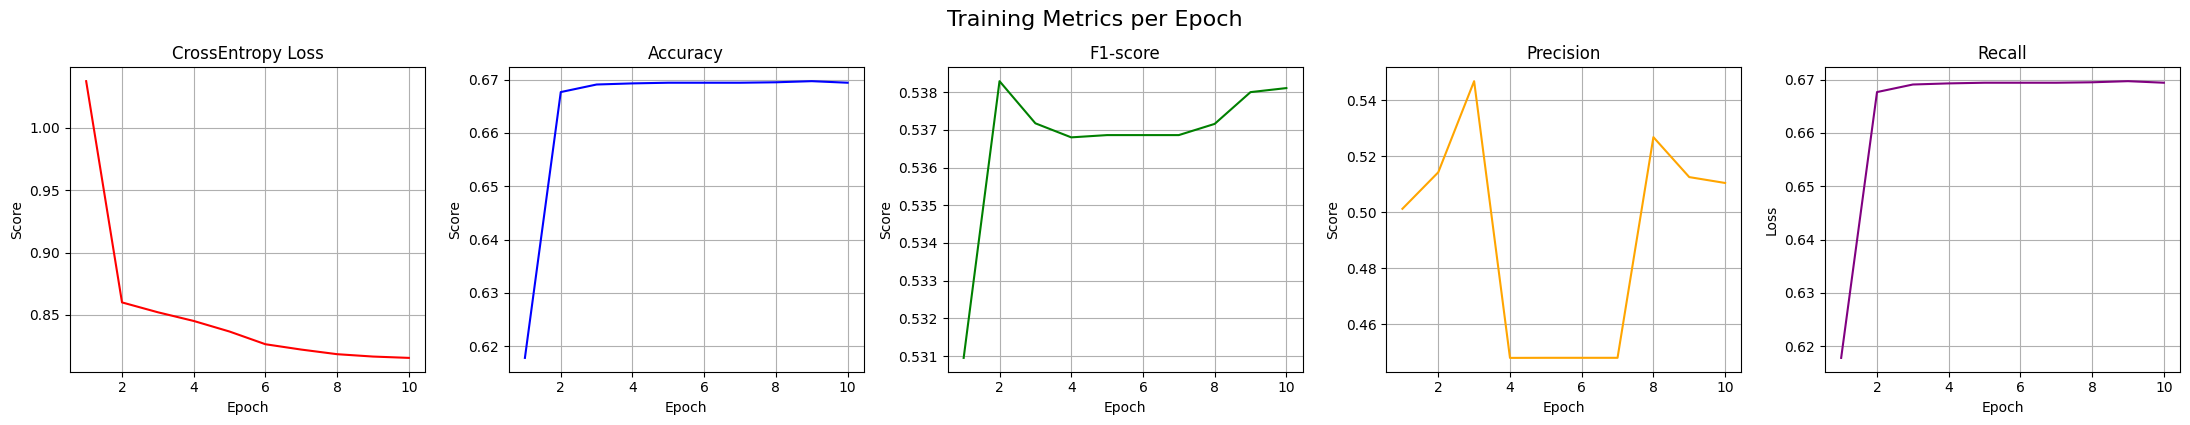

Plotting for label 0


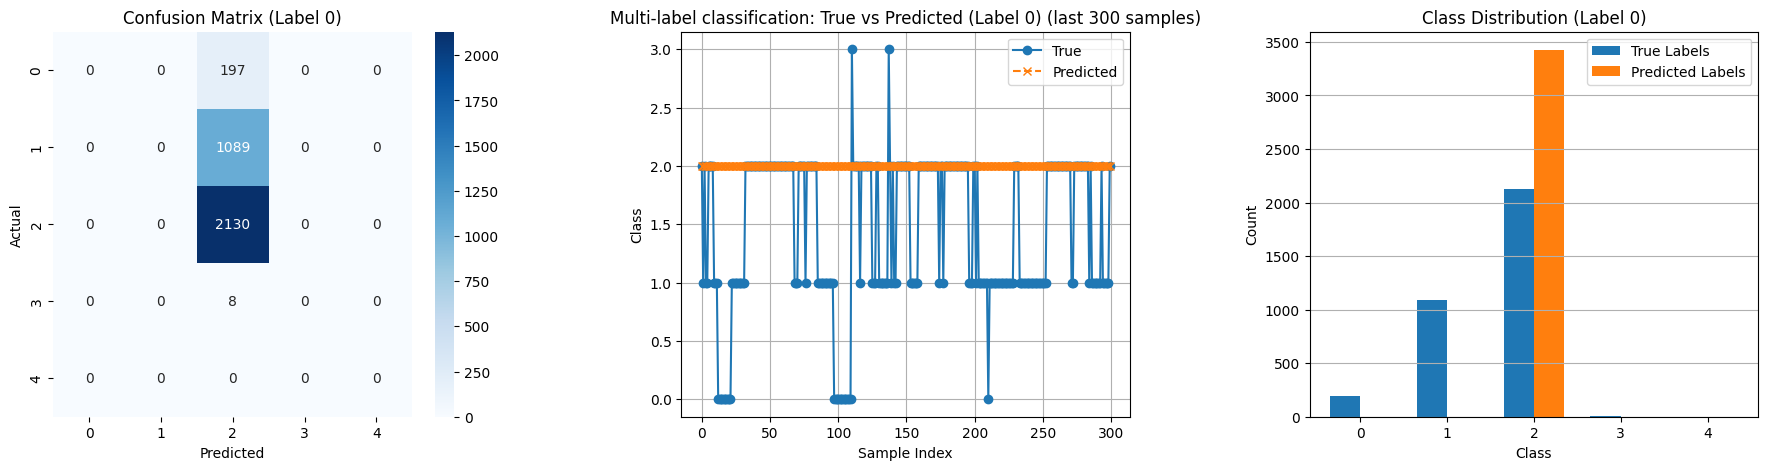

Plotting for label 1


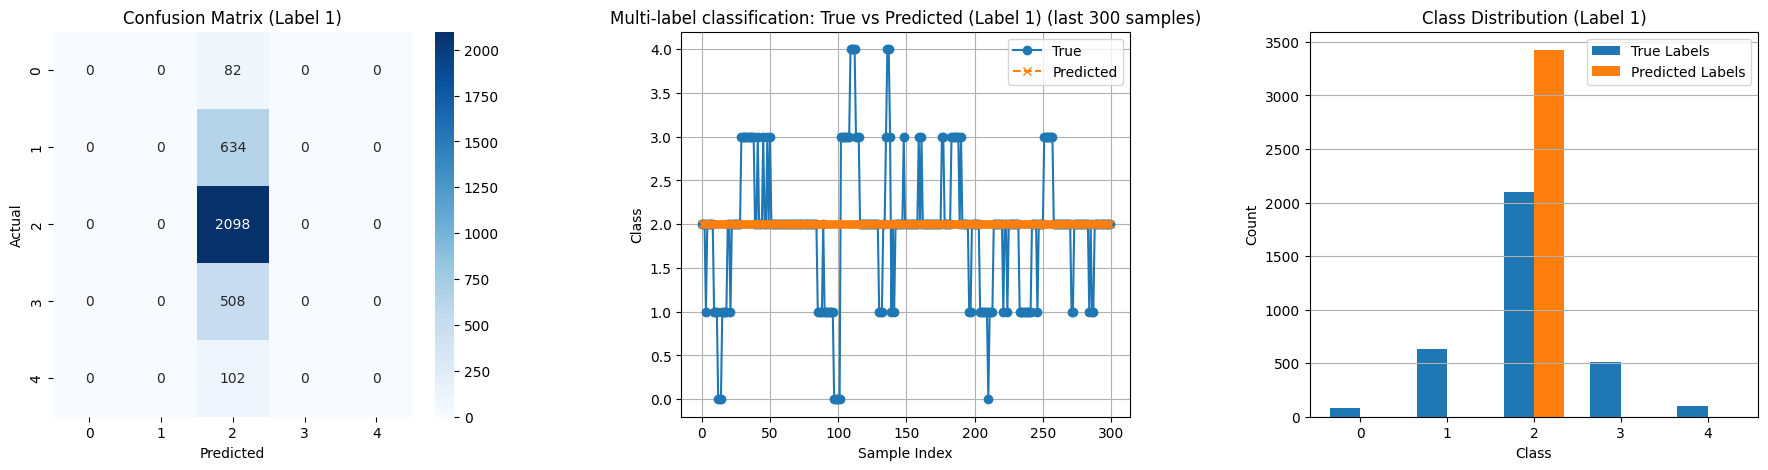

Plotting for label 2


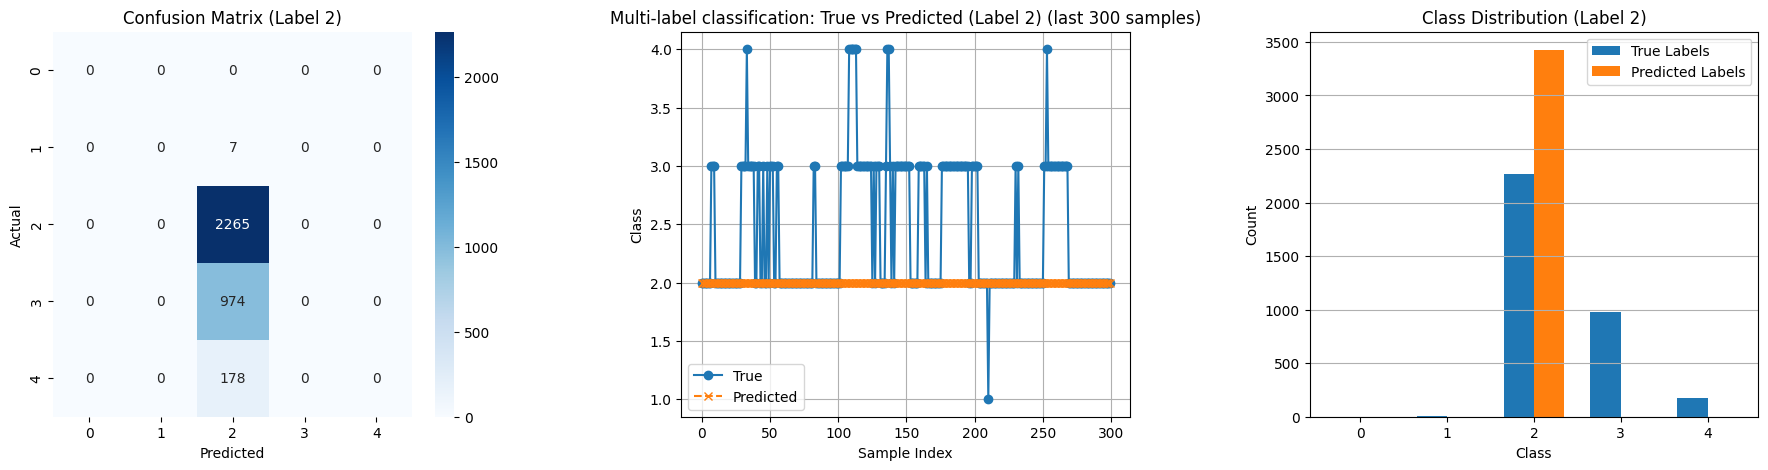

In [ ]:
#-------------------------------------------------------------------------------
# Supprimer les data du train précédent
list = ['model', 'optimiser']
for var in list:
    if var in locals():
        del globals()[var]

#-------------------------------------------------------------------------------

model = LSTM(
    input_dim=feature_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    num_epochs=num_epochs,
    n_labels=n_labels,
    n_categories=n_categories,
    dropout_p=dropout_p
)

#-------------------------------------------------------------------------------

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
model.criterion = nn.CrossEntropyLoss()

#-------------------------------------------------------------------------------

print("---------------------------------")
start_time = time.time()
for t in range(num_epochs):
    model.train()

    epoch_loss = 0.0
    all_preds = []
    all_targets = []

# -------------------------------------------------------

    for x_batch, y_batch in train_loader:
        y_pred_split = model(x_batch)  # tuple/list of 3 tensors
        y_pred = torch.cat(y_pred_split, dim=1)  # → (batch_size, 3×7)

        loss = model.multi_task_loss(y_pred_split, y_batch)
        epoch_loss += loss.item()

        all_preds.append(y_pred.detach().cpu())  # OK maintenant
        all_targets.append(y_batch.detach().cpu())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_epoch_pred = torch.cat(all_preds, dim=0)
    y_epoch_true = torch.cat(all_targets, dim=0)
    model.update_metrics(y_epoch_pred, y_epoch_true)

    # ------------------ Validation phase ------------------

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            y_pred_split_val = model(x_val)
            loss_val = model.multi_task_loss(y_pred_split_val, y_val)
            val_loss += loss_val.item()

    val_loss /= len(val_dataset)
    scheduler.step(val_loss)

# -------------------------------------------------------

    if (t+1) % 10 == 0 or t == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {t+1} / Loss: {model.hist_criterion[t]:.4f} / Acc: {model.hist_acc[t]:.4f} / F1: {model.hist_f1[t]:.4f} / Precision: {model.hist_precision[t]:.4f} / Recall: {model.hist_recall[t]:.4f} / LR: {current_lr:.6f}")

# -------------------------------------------------------

training_time = time.time() - start_time
print("---------------------------------")
print(f"Training time: {training_time}")
print("--------------------------------")

#-------------------------------------------------------------------------------

# Get Prediction
y_test_pred, y_test_pred_list = model.get_pred(x_test)

#-------------------------------------------------------------------------------

# Affichage des métriques
model.show_metrics(y_test,y_test_pred,y_test_pred_list)
model.visualize_classification_results(
    y_true=y_test,
    y_pred=y_test_pred,
    n_categories=n_categories,
    sequence_title="Multi-label classification: True vs Predicted",
    max_points=300
)
#-------------------------------------------------------------------------------

# 📌 Planned Modifications to Apply


## 🔢 Raw Data
- X

## 🧠 Feature Data
- **Add (2 dims):**
  - Distance between Resistance level and Price
  - Distance between Price and Support Level
- **Add (2 dims):**
  - Distance between VWAP POC High and Price
  - Distance between Price and VWAP POC Low

- **Add (8 dims):** Boolean flags indicating whether the current High or Low equals those of:
  - 1D, 4H, 1H, or 15M timeframes

## 🎯 Label Data
- **Change (2 dims):** Replace raw `Low`/`High` with `hit_high` and `hit_low`  
  *(True if high or low is reached within the next x candles)*
- **Add (2 dims):** Add `hit_high_vwap_poc` and `hit_low_vwap_poc`  
  *(True if high or low is reached within the next x candles)*

- **Remove (1 dim):** remove multi Categorization, keep just 2 categories (=Bool) per dims in labels

## 🚀 Performance Optimization
- Standardize variable naming to improve code clarity and maintainability
- Add an optimization loop to test model performance across all variable combinations
- Warring about CPU in model training
- rajouter amp optimization
- rajouter enregistremnt du modele à lafin
Data Loading and Preprocessing:

Data Prefetching: Overlap data loading with model training. Use the DataLoader with num_workers > 0 in PyTorch to load data in parallel.
Caching: If your dataset fits in memory, cache it to avoid repeated disk reads.
Efficient Data Formats: Use optimized data formats like TFRecord (TensorFlow) or optimized NumPy arrays.
Model Architecture and Training:

Gradient Accumulation: Simulate larger batch sizes by accumulating gradients over multiple smaller batches. Useful when memory is limited.
Gradient Clipping: Prevent exploding gradients by clipping their magnitude.
Learning Rate Scheduling: Adjust the learning rate during training (e.g., using ReduceLROnPlateau, cosine annealing) for better convergence.
Early Stopping: Stop training early if the validation loss plateaus or starts increasing to prevent overfitting.
Regularization Techniques: Use dropout, weight decay (L2 regularization), or other regularization methods to prevent overfitting.
Pruning: Remove less important connections in the neural network to reduce computational cost and sometimes improve generalization.
Quantization: Reduce the precision of weights and activations (e.g., to int8) after training for faster inference.
Hardware and Software:

GPU Utilization: Monitor GPU utilization to ensure it's being fully used. Profiling tools can help identify bottlenecks.
Distributed Training: Train across multiple GPUs or machines to speed up training. Libraries like PyTorch DistributedDataParallel and Horovod can be used.
Optimized Libraries: Use optimized deep learning libraries like cuDNN and MKL.
Profiling: Use profiling tools like PyTorch Profiler or TensorBoard to identify performance bottlenecks in your code.
Specific to LSTMs:

CuDNN LSTM: In PyTorch, ensure you are using the torch.nn.LSTM with cudnn=True if you're on a GPU. This uses a highly optimized NVIDIA CuDNN implementation.
Packing Sequences: If you have variable-length sequences, use torch.nn.utils.rnn.pack_padded_sequence and torch.nn.utils.rnn.pad_packed_sequence to avoid unnecessary padding computations.
